Epoch: 1000 cost = 0.002715
Epoch: 2000 cost = 0.000692
Epoch: 3000 cost = 0.000289
Epoch: 4000 cost = 0.000144
Epoch: 5000 cost = 0.000077
you love me is Bad Mean...


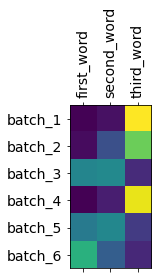

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__() #nn.Module(부모 클래스)의 init 호출

        self.embedding = nn.Embedding(vocab_size, embedding_dim) #(vocab_size * embedding_dim) 임베딩 벡터를 만들어서 학습
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True) #(input size, hidden size(출력 벡터의 크기), 양방향 모델 사용하는 것으로) 해서 LSTM 설정
        self.out = nn.Linear(n_hidden * 2, num_classes) # fc layer 정의(input, output)

    # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)] # lstm이 양방향이면 num_directions = 2여야 함 #num_layers = 2 면 두 개의 LSTM을 함께 쌓아 쌓인 LSTM을 형성하는 것을 의미.
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step] 2번째 인덱스(즉, 3번째) 차원이 1이면 압축해줌 bmm계산하고 나면 (6,3,1)임. 이걸 (6,3)으로 바꿔줌 
        soft_attn_weights = F.softmax(attn_weights, 1) # 뒤에가 1인것은 인덱스 1(2번째 차원)에 softmax해준단 소리. 즉 , 현재 atten_weights.shape은 (6,3)이고 3에 대해서 softmax해준단 소리
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim] (문장갯수, 각 문장의 길이(단어 3개씩임 예제에선), embedding_dim=2)
        input = input.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim] 차원 순서 바꿔줌

        hidden_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state)) #nn.LSTM의 output shape은 (seq_len, batch, num_directions * hidden_size)
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden*num_directions]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

if __name__ == '__main__':
    embedding_dim = 2 # embedding size
    n_hidden = 5  # number of hidden units in one cell
    num_classes = 2  # 0 or 1

    # 3 words sentences (=sequence_length is 3)
    sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
    labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list)) #set은 중복제거해주는 것.
    word_dict = {w: i for i, w in enumerate(word_list)}
    vocab_size = len(word_dict)

    model = BiLSTM_Attention()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #model.parameters()로 가중치와 bias를 불러와 전달하는 것.

    inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences]) #asarray는 데이터 형태가 다를 경우에만 복사를 해줌. inputs에 [word_dict[n]]을 복사해줌
    targets = torch.LongTensor([out for out in labels])  # To using Torch Softmax Loss function

    # Training
    for epoch in range(5000):
        optimizer.zero_grad() #이전 epoch에서 계산되어 있는 parameter의 gradient를 0으로 초기화한다.
        output, attention = model(inputs)
        loss = criterion(output, targets)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward() #back propagation을 통해 계산된 gradient 값을 각 파라미터에 할당
        optimizer.step() #각 파라미터별 할당된 gradient 값을 이용해 파라미터 값 업데이트

    # Test
    test_text = 'you love me'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]
    test_batch = torch.LongTensor(tests)

    # Predict
    predict, _ = model(test_batch)
    predict = predict.data.max(1, keepdim=True)[1] #max함수.. 1이니깐 열 방향으로 최댓값, [1]이니깐 최댓값의 value가 아닌 index를 뽑아라.
    if predict[0][0] == 0:
        print(test_text,"is Bad Mean...")
    else:
        print(test_text,"is Good Mean!!")

    fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')#노란색이 값이 높고 파란색이 낮은,,
    ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
    plt.show()

In [3]:
print(word_dict)

{'you': 0, 'that': 1, 'for': 2, 'i': 3, 'loves': 4, 'he': 5, 'she': 6, 'me': 7, 'likes': 8, 'baseball': 9, 'sorry': 10, 'is': 11, 'love': 12, 'this': 13, 'hate': 14, 'awful': 15}


In [4]:
print(vocab_size)

16


In [5]:
print(inputs)

tensor([[ 3, 12,  0],
        [ 5,  4,  7],
        [ 6,  8,  9],
        [ 3, 14,  0],
        [10,  2,  1],
        [13, 11, 15]])


In [6]:
print(inputs.shape)

torch.Size([6, 3])


In [8]:
print(targets.shape)

torch.Size([6])


In [ ]:
print(set(" ".join(sentences).split()))

{'he', 'i', 'hate', 'sorry', 'that', 'awful', 'you', 'me', 'is', 'she', 'this', 'loves', 'for', 'love', 'baseball', 'likes'}


In [ ]:
print(sentences)

['i love you', 'he loves me', 'she likes baseball', 'i hate you', 'sorry for that', 'this is awful']
